In [3]:
from core.imports import *
import csv

/usr/local/lib/python3.6/dist-packages/OpenSSL/crypto.py:8: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography import utils, x509


In [4]:
path = fs.join(ETL_PATH, job_name, 'SIGIR-ecom-data-challenge/train')

In [5]:
fs.glob(fs.join(path, '*csv'))

['/alloc/data/fury_user-navigation-research/etl/data/new_data/SIGIR-ecom-data-challenge/train/browsing_train.csv',
 '/alloc/data/fury_user-navigation-research/etl/data/new_data/SIGIR-ecom-data-challenge/train/search_train.csv',
 '/alloc/data/fury_user-navigation-research/etl/data/new_data/SIGIR-ecom-data-challenge/train/sku_to_content.csv',
 '/alloc/data/fury_user-navigation-research/etl/data/new_data/SIGIR-ecom-data-challenge/train/sorted_browsing_train.csv']

In [6]:
from core.embeddeddb2 import EmbeddedDB2

sku_edb = EmbeddedDB2(fs.join(path, 'sku_to_content.edb'), lock=False)
browsing_edb = EmbeddedDB2(fs.join(path, 'browsing_train.edb'), lock=False)

In [9]:
def parse_vector(v_str, asarray=False):
    if v_str:
        res = json.loads(v_str)
        if asarray:
            res = np.asarray(res)
        return res

def get_sku(sku):
    res = sku_edb.get(sku)
    if res is None: return
    res = res.copy()
    res['image_vector'] = parse_vector(res['image_vector'])
    res['description_vector'] = parse_vector(res['description_vector'])
    if res['price_bucket']: res['price_bucket'] = float(res['price_bucket'])
    else: res['price_bucket'] = None
    return res
    

def iter_enriched(censor_sessions=True):
    with open(fs.join(path, 'search_train.csv')) as f:
        search_reader = csv.DictReader(f)
        for doc in search_reader:
            if not doc['clicked_skus_hash']: continue
            if not doc['product_skus_hash']: continue
            
            doc['query_vector'] = parse_vector(doc['query_vector'])
            
            doc = dict(doc)
            doc['clicked_skus_hash'] = json.loads(doc['clicked_skus_hash'].replace("'", '"'))
            doc['product_skus_hash'] = json.loads(doc['product_skus_hash'].replace("'", '"'))

            doc['clicked_skus'] = [get_sku(k) for k in doc['clicked_skus_hash']]
            doc['product_skus'] = [get_sku(k) for k in doc['product_skus_hash']]

            doc['server_timestamp_epoch_ms'] = int(doc['server_timestamp_epoch_ms'])
            session = browsing_edb.get(doc['session_id_hash']) 
            if session is None: continue
            for e in session:
                e['server_timestamp_epoch_ms'] = int(e['server_timestamp_epoch_ms'])
            
            clicked = set(doc['clicked_skus_hash'])
            session.sort(key=lambda x: x['server_timestamp_epoch_ms'])


            trimmed_session = []
            for e in session:
                if e['product_sku_hash'] == '': continue
                if censor_sessions:
                    if e['server_timestamp_epoch_ms'] >= doc['server_timestamp_epoch_ms']: break
                    if e['product_sku_hash'] in clicked: break
                trimmed_session.append(e)

            doc['session'] = trimmed_session
            for e in doc['session']:
                prod = get_sku(e['product_sku_hash'])
                e.update(prod)
            
            doc['session'] = [
                e for e in doc['session'] 
                if  e['description_vector'] is not None
                and e['price_bucket'] is not None
#                 and e['image_vector'] is not None 
            ]
            if len(doc['session']) == 0: continue
            
            yield doc

In [ ]:
write_jl(progress(iter_enriched()), fs.join(path, 'joined_data.jl.gz'))

2022-09-27 12:53:53 pid 25394 | starting to iterate, updating every 1 seconds
2022-09-27 12:53:54 pid 25394 | 52, speed: 72.63 it/s, elapsed 0.72 seconds
2022-09-27 12:53:55 pid 25394 | 133, speed: 77.20 it/s, elapsed 1.72 seconds
2022-09-27 12:53:56 pid 25394 | 214, speed: 78.37 it/s, elapsed 2.73 seconds
2022-09-27 12:53:57 pid 25394 | 313, speed: 83.40 it/s, elapsed 3.75 seconds
2022-09-27 12:53:58 pid 25394 | 385, speed: 80.82 it/s, elapsed 4.76 seconds
2022-09-27 12:53:59 pid 25394 | 507, speed: 87.84 it/s, elapsed 5.77 seconds
2022-09-27 12:54:00 pid 25394 | 631, speed: 93.14 it/s, elapsed 6.78 seconds
2022-09-27 12:54:01 pid 25394 | 735, speed: 94.26 it/s, elapsed 7.80 seconds
2022-09-27 12:54:02 pid 25394 | 817, speed: 92.81 it/s, elapsed 8.80 seconds
2022-09-27 12:54:03 pid 25394 | 893, speed: 91.05 it/s, elapsed 9.81 seconds
2022-09-27 12:54:03 pid 25394 | print interval is now 5s
2022-09-27 12:54:08 pid 25394 | 1492, speed: 100.72 it/s, elapsed 14.81 seconds
2022-09-27 12:54

In [ ]:
write_jl(progress(iter_enriched(censor_sessions=False)), fs.join(path, 'joined_data_uncensored.jl.gz'))

In [7]:
ranks = []
for doc in progress(iter_jl(fs.join(path, 'joined_data.jl.gz'), limit=100_000)):
    clicked_ids = doc['clicked_skus_hash']
    printed_ids = doc['product_skus_hash']
    indices = [printed_ids.index(e) for e in clicked_ids if e in printed_ids]
    if not indices: continue
    r = min(indices)
    ranks.append(r)

2022-08-12 19:33:14 pid 12467 | starting to iterate, updating every 1 seconds
2022-08-12 19:33:15 pid 12467 | 1215, speed: 929.85 it/s, elapsed 1.31 seconds
2022-08-12 19:33:16 pid 12467 | 2147, speed: 930.55 it/s, elapsed 2.31 seconds
2022-08-12 19:33:17 pid 12467 | 2992, speed: 904.57 it/s, elapsed 3.31 seconds
2022-08-12 19:33:18 pid 12467 | 3828, speed: 888.41 it/s, elapsed 4.31 seconds
2022-08-12 19:33:19 pid 12467 | 4652, speed: 876.04 it/s, elapsed 5.31 seconds
2022-08-12 19:33:20 pid 12467 | 5448, speed: 863.34 it/s, elapsed 6.31 seconds
2022-08-12 19:33:21 pid 12467 | 6307, speed: 862.65 it/s, elapsed 7.31 seconds
2022-08-12 19:33:22 pid 12467 | 7309, speed: 879.33 it/s, elapsed 8.31 seconds
2022-08-12 19:33:23 pid 12467 | 8297, speed: 890.87 it/s, elapsed 9.31 seconds
2022-08-12 19:33:24 pid 12467 | print interval is now 5s
2022-08-12 19:33:28 pid 12467 | 13883, speed: 969.87 it/s, elapsed 14.31 seconds
2022-08-12 19:33:33 pid 12467 | 19507, speed: 1009.93 it/s, elapsed 19.32

<AxesSubplot:ylabel='Count'>

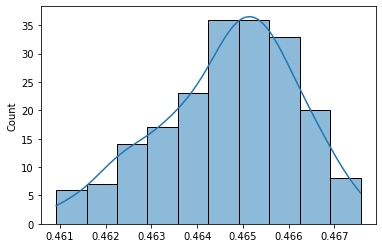

In [41]:
import seaborn as sns
s = pd.Series(ranks)

mrrs = []
for i in range(200):
    mrrs.append(
        (1.0/(1+s.sample(frac=1, replace=True))).mean()
    )
    
sns.histplot(mrrs, kde=True)

In [49]:
it = iter_jl(fs.join(path, 'joined_data.jl.gz'))

In [ ]:
def 

In [50]:
doc = next(it)
# doc.pop('clicked_skus_hash')
# doc.pop('product_skus_hash')
doc

{'session_id_hash': '8bb021a4d58b148cf577ecbe28aafa7d8a6b03caf6a6377b00d7dc2accbedc3b',
 'query_vector': [-0.033466748893260956,
  0.06939797103404999,
  -0.28429341316223145,
  0.1768970936536789,
  -0.07335524260997772,
  -0.16429854929447174,
  -0.019699834287166595,
  -0.02235899120569229,
  -0.07693640887737274,
  0.08092068880796432,
  -0.0015517491847276688,
  0.06702989339828491,
  -0.05085589364171028,
  0.22413626313209534,
  0.1651172935962677,
  0.06769104301929474,
  0.016391493380069733,
  -0.003987145610153675,
  -0.014643985778093338,
  -0.046426136046648026,
  -0.02342291921377182,
  0.01617286540567875,
  0.20202383399009705,
  -0.05279499292373657,
  -0.01927248202264309,
  0.03032820299267769,
  0.020952755585312843,
  0.11230775713920593,
  0.052077535539865494,
  0.007175826001912355,
  0.1186031699180603,
  -0.07730421423912048,
  -0.02895934134721756,
  -0.07657062262296677,
  0.004897903650999069,
  0.09117341041564941,
  0.032685644924640656,
  -0.021437473595

In [14]:
debug

> <ipython-input-10-0644266c3897>(6)get_sku()
      4     res = res.copy()
      5     print(type(res['image_vector']))
----> 6     res['image_vector'] = np.asarray(json.loads(res['image_vector']))
      7     res['description_vector'] = np.asarray(json.loads(res['description_vector']))
      8     res['price_bucket'] = float(res['price_bucket'])



ipdb>  print(type(res['image_vector']))


<class 'str'>


ipdb>  json.loads(res['image_vector'])


*** ValueError: Expected object or value


ipdb>  res['image_vector']


''


ipdb>  q


In [92]:
debug

> <ipython-input-89-53d55c206d57>(4)get_sku()
      2     res = sku_edb.get(sku)
      3     if res is None: return
----> 4     res['image_vector'] = np.asarray(json.loads(res['image_vector']))
      5     res['description_vector'] = np.asarray(json.loads(res['description_vector']))
      6     res['price_bucket'] = float(res['price_bucket'])



ipdb>  res['image_vector']


array([ 2.54262331e+02, -2.37503784e+01,  8.71443091e+01, -5.91602251e+01,
       -1.32575832e+02,  7.29521750e+01, -1.53576695e+01, -3.14653007e+01,
        1.52644741e+02,  1.91350197e+01,  7.26679933e+01, -1.86745615e+02,
       -6.53385410e+01, -5.15280136e+01, -1.31789426e+02,  1.33951767e+02,
        1.03060627e+02,  3.78910826e+01,  2.41055222e+01,  7.75514097e+01,
        1.54947841e+01, -7.22783307e+01,  2.50355557e+01,  1.14824939e+01,
        4.20735565e+01,  3.34340535e+01,  3.92300456e+01, -7.49837597e+00,
       -5.28394211e+01, -5.39301191e+01, -4.08824372e+01,  2.01207624e+01,
        9.89893858e+00, -3.74369733e+01,  6.73493699e+00,  2.86838902e-02,
       -4.06200756e-01, -7.85337184e+00,  6.61182526e+01,  2.28528543e+01,
        2.53940184e+01,  2.12389318e+00,  2.44238410e+01,  1.34967413e+01,
       -1.84670289e+01, -7.70694873e+00, -4.70553339e+01,  2.34942421e+01,
       -6.23081803e+01,  1.61152381e+01])


ipdb>  q
